In [34]:
import pandas as pd
import numpy as np
import scipy.integrate
import scipy.special
from scipy.special import inv_boxcox
from scipy import stats
import seaborn as sns
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import pylab
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from matplotlib.ticker import PercentFormatter
from scipy.stats import boxcox

In [2]:
pd.set_option('display.max_rows', 500)

&nbsp;


&nbsp;


# Reading in Data

In [3]:
finaldataset = pd.read_csv("../Downloads/finaldataset.csv")

In [4]:
finaldataset.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
finaldataset.shape

(18917, 102)

&nbsp;


__change features to categorical__

In [6]:
category_columns = ['sex', 'income', 'entrepreneur_freelancer', 
                     'entrepreneur_freelancer_alongside', 'one_person_business', 'income', 
                     'company_owner', 'partnership', 'partner_partnership', 
                     'private_limited_liability_company', 'other', 'none_work_situation', 
                     'early_retirement', 'zorgtoeslag', 'Ziektewetuitkering', 
                     'ANW', 'nabestaandenpensioen', 'orphan_pension', 'bijstand', 
                     'bijstand_zelfstandigen', 'IOAWIOAZ', 'WGA', 'invadility_pension', 
                     'kinderbijslag', 'none_benefit', 'income_realestate', 'student_grant', 
                     'student_loan', 'alimony_ex', 'alimony_children', 'study_allowance_parents', 
                     'allowence_family', 'dividend_stock_investment', 'interests', 
                     'none_sources', 'interest_loans', 'alimony_ex_paid', 'alimony_children_paid',
                     'parental_support_paid', 'parental_support_paid_other', 'support_gift_paid', 
                     'big_purchase', 'no_arrears', 'rent_mortgage_arrears',  
                     'general_utilities_arrear', 'other_arrears', 'months_arrears_rent', 
                     'months_arrears_general_utilities', 'partyvote', 'age_2', 'satisfaction_individual_2', 
                     'satisfaction_national_2', 'income_2', 
                     'gross_wages_amount_2', 'entrepreneur_freelancer_2', 
                     'entrepreneur_freelancer_alongside_2', 'one_person_business_2', 
                     'company_owner_2', 'partnership_2', 'partner_partnership_2', 
                     'private_limited_liability_company_2', 'other_2', 'none_work_situation_2', 
                     'zorgtoeslag_2', 'Ziektewetuitkering_2', 
                     'ANW_2', 'nabestaandenpensioen_2', 'bijstand_2', 
                     'bijstand_zelfstandigen_2', 'IOAWIOAZ_2', 'WGA_2', 'invadility_pension_2', 
                     'kinderbijslag_2', 'none_benefit_2', 'income_realestate_2', 'realestate_amount_2', 'student_grant_2', 
                     'amount_student_grant_2', 'student_loan_2', 'amount_student_loan_2', 'alimony_ex_2', 
                     'amount_alimony_ex_2', 
                     'alimony_children_2', 'amount_alimony_children_2', 'study_allowance_parents_2', 
                     'amount_study_allowance_parents_2', 
                     'allowence_family_2', 'amount_allowance_family_2', 'dividend_stock_investment_2', 
                     'amount_dividend_stock_investment_2',
                     'interests_2', 'amount_interests_2', 
                     'none_sources_2', 'interest_loans_2', 'amount_interest_loans_2', 'parental_support_paid_other_2', 
                     'support_gift_paid_2', 'amount_support_gift_paid_2',
                     'taxable_income_2', 'net_income_household_2', 'financial_situation_grade_2', 
                     'difficulty_life_grade_2', 'financial_situation_category_2', 'household_expenditure_2', 
                     'big_purchase_2', 'financial_situation_future_2', 'no_arrears_2', 
                     'rent_mortgage_arrears_2', 'amount_rent_mortgage_arrears_2', 'general_utilities_arrear_2', 
                     'amount_general_utilities_arrear_2',  
                     'other_arrears_2', 'amount_other_arrears_2', 'months_arrears_rent_2', 
                     'months_arrears_general_utilities_2']

&nbsp;


In [7]:
for col in finaldataset.columns:
    for i in category_columns:
        if col == i:
            finaldataset[col] = finaldataset[col].astype('category')

In [8]:
finaldataset.dtypes

date                                    float64
sex                                    category
age                                     float64
satisfaction_individual                   int64
satisfaction_individual_2              category
satisfaction_national                     int64
satisfaction_national_2                category
income                                 category
income_2                               category
entrepreneur_freelancer                category
entrepreneur_freelancer_2              category
entrepreneur_freelancer_alongside      category
entrepreneur_freelancer_alongside_2    category
one_person_business                    category
one_person_business_2                  category
company_owner                          category
company_owner_2                        category
partnership                            category
partnership_2                          category
partner_partnership                    category
partner_partnership_2                  c

&nbsp;


&nbsp;


# Split into train/validation and test set

In [9]:
test_set = finaldataset.loc[finaldataset.date > 202105, :].copy()
train_set = finaldataset.loc[finaldataset.date < 202105, :].copy()

In [10]:
print(train_set.shape)
print(test_set.shape)

(15200, 102)
(3717, 102)


In [11]:
train_set['partyvote'].value_counts(normalize=True) * 100

VVD      20.184211
PvdA     18.361842
CDA      15.532895
SP       12.322368
PVV       8.414474
D66       8.032895
GL        6.440789
CU        3.842105
other     2.750000
PvdD      1.973684
SGP       1.750000
blank     0.394737
Name: partyvote, dtype: float64

In [12]:
test_set['partyvote'].value_counts(normalize=True) * 100

VVD      21.011568
D66      15.657789
other    13.101964
CDA      10.196395
PvdA      8.797417
PVV       8.097928
SP        6.994888
GL        5.891848
PvdD      4.627388
CU        3.766478
SGP       1.506591
blank     0.349744
Name: partyvote, dtype: float64

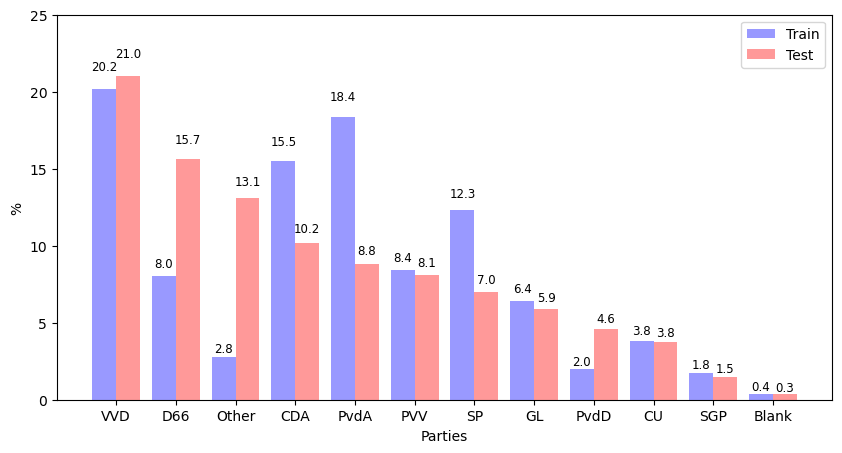

In [35]:
features = ['VVD', 'D66', 'Other', 'CDA', 'PvdA', 'PVV', 'SP', 'GL', 'PvdD', 'CU', 'SGP', 'Blank']
proportions_1 = [20.18, 8.03, 2.75, 15.53, 18.36, 8.41, 12.32, 6.44, 1.97, 3.84, 1.75, 0.39]

proportions_2 = [21.01, 15.65, 13.10, 10.19, 8.79, 8.09, 6.99, 5.89, 4.62, 3.76, 1.50, 0.34]

fig, ax = plt.subplots(figsize=(10,5))
width = 0.4
x = np.arange(len(features))
rects1 = ax.bar(x - width/2, proportions_1, width, color='blue', label='Train', alpha=0.4)
rects2 = ax.bar(x + width/2, proportions_2, width, color='red', label='Test', alpha=0.4)
ax.set_ylim(0, 25)

ax.set_xticks(x)
ax.set_xticklabels(features)
ax.spines['top'].set_visible(True)

ax.set_xlabel('Parties')
ax.set_ylabel('%')

ax.legend()

for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%.1f' % height,
            ha='center', va='bottom', fontsize=8.5)

for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%.1f' % height,
            ha='center', va='bottom', fontsize=8.5)

plt.show()

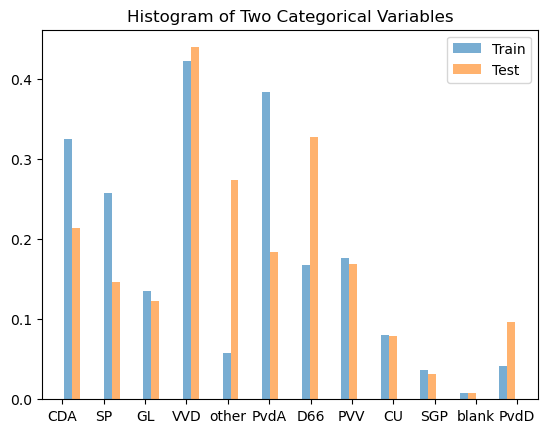

In [13]:
fig, ax = plt.subplots()

ax.hist([train_set['partyvote'], test_set['partyvote']], alpha=0.6, label=['Train', 'Test'], stacked=False, bins = 23, density=True)

ax.legend()
ax.set_title('Histogram of Two Categorical Variables')

plt.show()

&nbsp;


&nbsp;


__calculate percentages of train and test split__

In [14]:
print(len(train_set.index)/len(finaldataset.index)*100)
print(len(test_set.index)/len(finaldataset.index)*100)

80.35100703071312
19.648992969286887


&nbsp;


&nbsp;

# Box-Cox continuous non-normal variables

&nbsp;

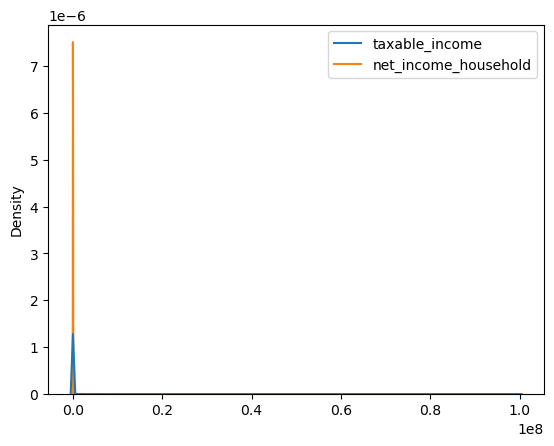

In [15]:
cols1 = train_set[['taxable_income', 'net_income_household']]
cols2 = test_set[['taxable_income', 'net_income_household']]

df = pd.concat([cols1, cols2], axis=1)

sns.kdeplot(df)

plt.show()

In [16]:
cols1 = cols1.rename(columns={'taxable_income':'taxable_income train','net_income_household':'net_income_household train'})
cols2 = cols2.rename(columns={'taxable_income':'taxable_income test','net_income_household':'net_income_household test'})

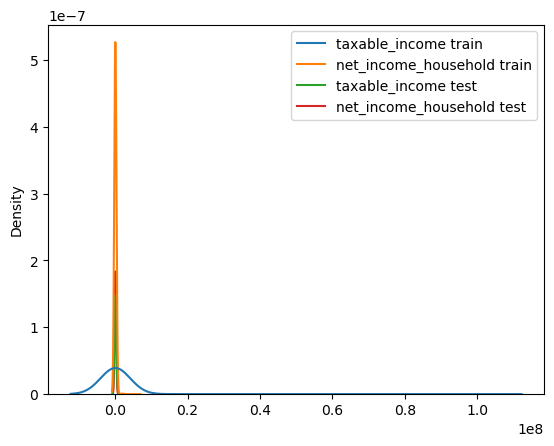

In [17]:
df = pd.concat([cols1, cols2], axis=1)

sns.kdeplot(df, bw_adjust=20)

plt.show()

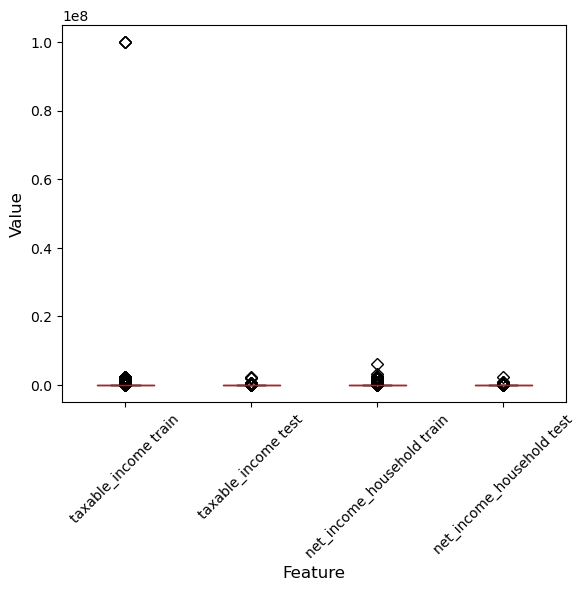

In [18]:
medianprops = {'color': 'red'}
boxprops = {'color': 'black'}
whiskerprops = {'color': 'black'}
capprops = {'color': 'black'}
flierprops = {'color': 'black', 'marker': 'D'}

data = [train_set['taxable_income'], test_set['taxable_income'], train_set['net_income_household'], test_set['net_income_household']]
labels = ['taxable_income train', 'taxable_income test', 'net_income_household train', 'net_income_household test']

fig = plt.figure(figsize=(6.5, 4.9))
ax = fig.add_subplot(111)

bp = ax.boxplot(data, labels=labels, patch_artist=True, medianprops=medianprops, 
                boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
                flierprops=flierprops)
plt.xticks(rotation=45)

colors = ['#0000FF', '#00FF00', '#FFFF00', '#FF00FF']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xlabel('Feature', fontsize=12)
ax.set_ylabel('Value', fontsize=12)

plt.show()

In [19]:
train_set['taxable_income'].nlargest(n=20)

6132     100000000.0
5323      99999999.0
17702     99999999.0
4203       2358300.0
12394      2358300.0
13010      2358300.0
13437      2358300.0
17196      2358300.0
4744       1781300.0
5771       1781300.0
7347       1781300.0
9582       1781300.0
13691      1781300.0
14241      1781300.0
15001      1781300.0
15882      1781300.0
18284      1781300.0
12680      1317300.0
12743      1317300.0
11607      1204200.0
Name: taxable_income, dtype: float64

In [20]:
test_set['taxable_income'].nlargest(n=20)

2808    2358300.0
1329    2008000.0
3078    2008000.0
872      600000.0
3513     541000.0
2125     485667.0
3169     485667.0
403      325000.0
1757     300070.0
2351     281040.0
3127     279000.0
1207     262000.0
2536     250000.0
719      241917.0
2934     240000.0
3533     240000.0
156      231869.0
3536     230000.0
2983     217937.0
3640     216000.0
Name: taxable_income, dtype: float64

In [21]:
train_set['net_income_household'].nlargest(n=20)

7080     6000000.0
16992    3052816.0
11607    2709400.0
8235     2375150.0
15001    2375150.0
7347     2140600.0
12743    2140600.0
15953    2140600.0
18664    2140600.0
9582     2137065.0
11699    2137065.0
13080    2137065.0
13556    2137065.0
17196    2137065.0
18284    2137065.0
3844     1936260.0
5771     1936260.0
6137     1936260.0
12394    1936260.0
12680    1936260.0
Name: net_income_household, dtype: float64

In [22]:
test_set['net_income_household'].nlargest(n=20)

3078    2375150.0
403      980000.0
3299     980000.0
647      540000.0
1614     500000.0
2997     500000.0
3169     500000.0
1819     333769.0
437      300000.0
1530     299770.0
2608     294684.0
2934     269524.0
3339     265000.0
555      264000.0
854      250000.0
1329     250000.0
3446     240000.0
227      233000.0
3533     233000.0
581      232135.0
Name: net_income_household, dtype: float64

&nbsp;

__have to add constant to the value, because box-cox does not handle negative values__

In [23]:
min_train_tax = min(train_set['taxable_income'])
min_test_tax = min(test_set['taxable_income'])

min_train_house = min(train_set['net_income_household'])
min_test_house = min(test_set['net_income_household'])

In [24]:
train_set['taxable_income'] = train_set['taxable_income'] - min_train_tax + 1 
test_set['taxable_income'] = test_set['taxable_income'] - min_test_tax + 1

train_set['net_income_household'] = train_set['net_income_household'] - min_train_house + 1 
test_set['net_income_household'] = test_set['net_income_household'] - min_test_house + 1

&nbsp;

In [25]:
cols = ['taxable_income', 'net_income_household']

lambda_vals = {}
for col in cols:
    train_set[col], lambda_val = boxcox(train_set[col])
    test_set[col] = boxcox(test_set[col], lmbda=lambda_val)
    lambda_vals[col] = lambda_val

&nbsp;

__Lambda value (power to which data raised)__

In [27]:
print(lambda_vals)

{'taxable_income': -0.034398270588177376, 'net_income_household': 0.045581457795245264}


&nbsp;

__apply to variables__

&nbsp;

__New distribution__

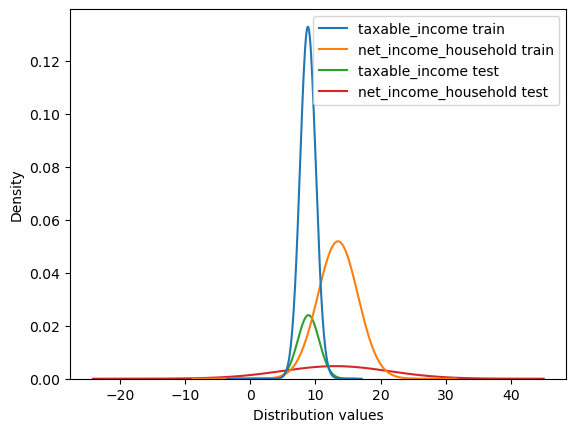

In [30]:
cols3 = train_set[['taxable_income', 'net_income_household']]
cols4 = test_set[['taxable_income', 'net_income_household']]

cols3 = cols3.rename(columns={'taxable_income':'taxable_income train','net_income_household':'net_income_household train'})
cols4 = cols4.rename(columns={'taxable_income':'taxable_income test','net_income_household':'net_income_household test'})

df = pd.concat([cols3, cols4], axis=1)

sns.kdeplot(df, bw_adjust=20)


plt.xlabel("Distribution values", size=10, color='black')


plt.show()

&nbsp;

&nbsp;

# minmax scale continuous variables

In [31]:
scaler = MinMaxScaler()

In [32]:
train_set[['taxable_income','net_income_household']] = scaler.fit_transform(train_set[['taxable_income','net_income_household']])
test_set[['taxable_income','net_income_household']] = scaler.fit_transform(test_set[['taxable_income','net_income_household']])

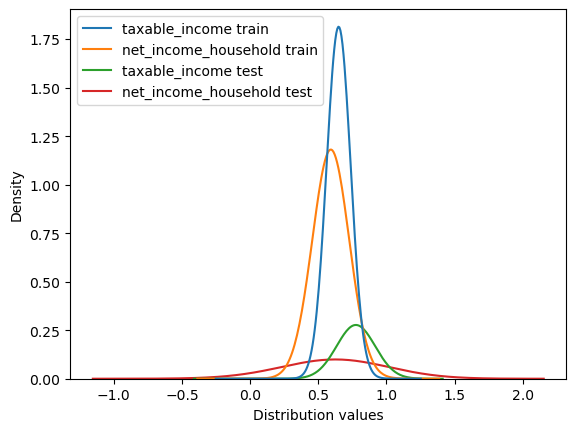

In [33]:
cols3 = train_set[['taxable_income', 'net_income_household']]
cols4 = test_set[['taxable_income', 'net_income_household']]

cols3 = cols3.rename(columns={'taxable_income':'taxable_income train','net_income_household':'net_income_household train'})
cols4 = cols4.rename(columns={'taxable_income':'taxable_income test','net_income_household':'net_income_household test'})

df = pd.concat([cols3, cols4], axis=1)

sns.kdeplot(df, bw_adjust=20)

plt.xlabel("Distribution values", size=10, color='black')


plt.show()

&nbsp;

&nbsp;

# Make dataset with added valence features

In [34]:
bbpdata = pd.read_csv("../Downloads/table_tabel-68f189ce-1767-4eed-9368-34d5efa455a6.csv")
inflatiedata = pd.read_csv("../Downloads/CPI__prijsindex_2015_100_17112022_134353.csv", sep = ';')
unemploymentdata = pd.read_csv("../Downloads/Arbeidsdeelname__kerncijfers_17112022_144331.csv", sep = ';')

__Prepare inflation, gdp, unemployment and incumbent columns__

_inflation_

In [35]:
inflatiedata = inflatiedata.drop(['Bestedingscategorieën'], axis=1)

In [36]:
inflatiedata

,Perioden,CPI (2015 = 100)
0,2002,80.74
1,2003,82.43
2,2004,83.48
3,2005,84.88
4,2006,85.82
5,2007,87.20
6,2008,89.37
7,2009,90.44
8,2010,91.59
9,2011,93.73


In [37]:
inflation_21 = inflatiedata['CPI (2015 = 100)'][19] - inflatiedata['CPI (2015 = 100)'][16]
inflation_17 = inflatiedata['CPI (2015 = 100)'][15] - inflatiedata['CPI (2015 = 100)'][11]
inflation_12 = inflatiedata['CPI (2015 = 100)'][10] - inflatiedata['CPI (2015 = 100)'][9]
inflation_10 = inflatiedata['CPI (2015 = 100)'][8] - inflatiedata['CPI (2015 = 100)'][5]
inflation_6 = inflatiedata['CPI (2015 = 100)'][4] - inflatiedata['CPI (2015 = 100)'][1]

In [38]:
def valence_inflation (row):
    if row['date'] == 202107. :
        return inflation_21
    if row['date'] == 202106 :
        return inflation_21
    if row['date'] == 201906 :
        return inflation_17
    if row['date'] == 201907:
        return inflation_17
    if row['date']  == 201207:
        return inflation_12
    if row['date'] == 201206:
        return inflation_12
    if row['date'] == 201006:
        return inflation_10
    if row['date'] == 201007:
        return inflation_10
    if row['date'] == 200806:
        return inflation_6
    if row['date'] == 200809:
        return inflation_6
    return 0

_gdp_

In [39]:
bbpdata = bbpdata.replace(',','.', regex=True)

In [40]:
bbpdata['Verandering (%-verandering t.o.v. jaar eerder)'] = bbpdata['Verandering (%-verandering t.o.v. jaar eerder)'].astype(float)

In [41]:
bbpdata

,Perioden,Verandering (%-verandering t.o.v. jaar eerder)
0,2000,4.2
1,2001,2.3
2,2002,0.2
3,2003,0.2
4,2004,2.0
5,2005,2.1
6,2006,3.5
7,2007,3.8
8,2008,2.2
9,2009,-3.7


In [42]:
gdp_2002 = ((100+(0.002*100)))
gdp_2003 = ((gdp_2002+(0.002*gdp_2002)))
gdp_2004 = ((gdp_2003+(0.02*gdp_2003)))
gdp_2005 = ((gdp_2004+(0.021*gdp_2004)))
gdp_2006 = ((gdp_2005+(0.035*gdp_2005)))
gdp_2007 = ((gdp_2006+(0.038*gdp_2006)))
gdp_2008 = ((gdp_2007+(0.022*gdp_2007)))
gdp_2009 = ((gdp_2008-(0.037*gdp_2008)))
gdp_2010 = ((gdp_2009+(0.013*gdp_2009)))
gdp_2011 = ((gdp_2010+(0.016*gdp_2010)))
gdp_2012 = ((gdp_2011-(0.01*gdp_2011)))
gdp_2013 = ((gdp_2012-(0.001*gdp_2012)))
gdp_2014 = ((gdp_2013+(0.014*gdp_2013)))
gdp_2015 = ((gdp_2014+(0.02*gdp_2014)))
gdp_2016 = ((gdp_2015+(0.022*gdp_2015)))
gdp_2017 = ((gdp_2016+(0.029*gdp_2016)))
gdp_2018 = ((gdp_2017+(0.024*gdp_2017)))
gdp_2019 = ((gdp_2018+(0.02*gdp_2018)))
gdp_2020 = ((gdp_2019-(0.038*gdp_2019)))
gdp_2021 = ((gdp_2020+(0.048*gdp_2020)))

In [43]:
def valence_gdp (row):
    if row['date'] == 202107. :
        return 100*((gdp_2021-gdp_2017)/gdp_2017)
    if row['date'] == 202106 :
        return 100*((gdp_2021-gdp_2017)/gdp_2017)
    if row['date'] == 201906 :
        return 100*((gdp_2017-gdp_2012)/gdp_2012)
    if row['date'] == 201907:
        return 100*((gdp_2017-gdp_2012)/gdp_2012)
    if row['date']  == 201207:
        return 100*((gdp_2012-gdp_2010)/gdp_2010)
    if row['date'] == 201206:
        return 100*((gdp_2012-gdp_2010)/gdp_2010)
    if row['date'] == 201006:
        return 100*((gdp_2010-gdp_2006)/gdp_2006)
    if row['date'] == 201007:
        return 100*((gdp_2010-gdp_2006)/gdp_2006)
    if row['date'] == 200806:
        return 100*((gdp_2006-gdp_2002)/gdp_2002)
    if row['date'] == 200809:
        return 100*((gdp_2006-gdp_2002)/gdp_2002)
    return 0

_unemployment_

In [44]:
unemploymentdata = unemploymentdata.drop(['Geslacht', 'Leeftijd', 'Hoogst behaald onderwijsniveau'], axis=1)

In [45]:
unemploymentdata

,Perioden,Netto arbeidsparticipatie (%)
0,2003,64.2
1,2004,63.8
2,2005,64.1
3,2006,65.0
4,2007,66.6
5,2008,67.9
6,2009,67.6
7,2010,66.7
8,2011,66.5
9,2012,66.4


In [46]:
unemployment_21 = unemploymentdata['Netto arbeidsparticipatie (%)'][22] - unemploymentdata['Netto arbeidsparticipatie (%)'][14]
unemployment_17 = unemploymentdata['Netto arbeidsparticipatie (%)'][14] - unemploymentdata['Netto arbeidsparticipatie (%)'][9]
unemployment_12 = unemploymentdata['Netto arbeidsparticipatie (%)'][9] - unemploymentdata['Netto arbeidsparticipatie (%)'][7]
unemployment_10 = unemploymentdata['Netto arbeidsparticipatie (%)'][7] - unemploymentdata['Netto arbeidsparticipatie (%)'][3]
unemployment_6 = unemploymentdata['Netto arbeidsparticipatie (%)'][3] - unemploymentdata['Netto arbeidsparticipatie (%)'][1]

In [47]:
def valence_unemployment (row):
    if row['date'] == 202107. :
        return unemployment_21
    if row['date'] == 202106 :
        return unemployment_21
    if row['date'] == 201906 :
        return unemployment_17
    if row['date'] == 201907:
        return unemployment_17
    if row['date']  == 201207:
        return unemployment_12
    if row['date'] == 201206:
        return unemployment_12
    if row['date'] == 201006:
        return unemployment_10
    if row['date'] == 201007:
        return unemployment_10
    if row['date'] == 200806:
        return unemployment_6
    if row['date'] == 200809:
        return unemployment_6
    return 0

_incumbent_

In [48]:
def incumbent_party(row):  
    if row['date'] == 202107 and row['partyvote'] == 'VVD':
        return 1
    elif row['date'] == 202106 and row['partyvote'] == 'VVD':
        return 1
    elif row['date'] == 201907 and row['partyvote'] == 'VVD':
        return 1
    elif row['date'] == 201906 and row['partyvote'] == 'VVD':
        return 1
    elif row['date'] == 201207 and row['partyvote'] == 'VVD':
        return 1
    elif row['date'] == 201206 and row['partyvote'] == 'VVD':
        return 1
    elif row['date'] == 200806 and row['partyvote'] == 'VVD':
        return 1
    elif row['date'] == 200809 and row['partyvote'] == 'VVD':
        return 1
    elif row['date'] == 202107 and row['partyvote'] == 'CDA':
        return 1
    elif row['date'] == 202106 and row['partyvote'] == 'CDA':
        return 1
    elif row['date'] == 201207 and row['partyvote'] == 'CDA':
        return 1
    elif row['date'] == 201206 and row['partyvote'] == 'CDA':
        return 1
    elif row['date'] == 201007 and row['partyvote'] == 'CDA':
        return 1
    elif row['date'] == 201006 and row['partyvote'] == 'CDA':
        return 1
    elif row['date'] == 200806 and row['partyvote'] == 'CDA':
        return 1
    elif row['date'] == 200809 and row['partyvote'] == 'CDA':
        return 1
    elif row['date'] == 202107 and row['partyvote'] == 'D66':
        return 1
    elif row['date'] == 202106 and row['partyvote'] == 'D66':
        return 1
    elif row['date'] == 200806 and row['partyvote'] == 'D66':
        return 1
    elif row['date'] == 200809 and row['partyvote'] == 'D66':
        return 1
    elif row['date'] == 202107 and row['partyvote'] == 'CU':
        return 1
    elif row['date'] == 202106 and row['partyvote'] == 'CU':
        return 1
    elif row['date'] == 201007 and row['partyvote'] == 'CU':
        return 1
    elif row['date'] == 201006 and row['partyvote'] == 'CU':
        return 1
    elif row['date'] == 201907 and row['partyvote'] == 'PvdA':
        return 1
    elif row['date'] == 201906 and row['partyvote'] == 'PvdA':
        return 1
    elif row['date'] == 201007 and row['partyvote'] == 'PvdA':
        return 1
    elif row['date'] == 201006 and row['partyvote'] == 'PvdA':
        return 1
    return 0

__apply formulas to columns__

In [49]:
train_set_val = train_set.copy()
test_set_val = test_set.copy()

In [50]:
train_set_val['GDP'] = train_set_val.apply (lambda row: valence_gdp(row), axis=1)
train_set_val['inflation'] = train_set_val.apply (lambda row: valence_inflation(row), axis=1)
train_set_val['unemployment'] = train_set_val.apply (lambda row: valence_unemployment(row), axis=1)
train_set_val['incumbent'] = train_set_val.apply (lambda row: incumbent_party(row), axis=1)

In [51]:
test_set_val['GDP'] = test_set_val.apply (lambda row: valence_gdp(row), axis=1)
test_set_val['inflation'] = test_set_val.apply (lambda row: valence_inflation(row), axis=1)
test_set_val['unemployment'] = test_set_val.apply (lambda row: valence_unemployment(row), axis=1)
test_set_val['incumbent'] = test_set_val.apply (lambda row: incumbent_party(row), axis=1)

__change order of columns__

In [52]:
my_list = list(train_set_val)

In [53]:
print(my_list)

['date', 'sex', 'age', 'satisfaction_individual', 'satisfaction_individual_2', 'satisfaction_national', 'satisfaction_national_2', 'income', 'income_2', 'entrepreneur_freelancer', 'entrepreneur_freelancer_2', 'entrepreneur_freelancer_alongside', 'entrepreneur_freelancer_alongside_2', 'one_person_business', 'one_person_business_2', 'company_owner', 'company_owner_2', 'partnership', 'partnership_2', 'partner_partnership', 'partner_partnership_2', 'private_limited_liability_company', 'private_limited_liability_company_2', 'other', 'other_2', 'none_work_situation', 'none_work_situation_2', 'zorgtoeslag', 'zorgtoeslag_2', 'Ziektewetuitkering', 'Ziektewetuitkering_2', 'ANW', 'ANW_2', 'nabestaandenpensioen', 'nabestaandenpensioen_2', 'bijstand', 'bijstand_2', 'bijstand_zelfstandigen', 'bijstand_zelfstandigen_2', 'IOAWIOAZ', 'IOAWIOAZ_2', 'WGA', 'WGA_2', 'invadility_pension', 'invadility_pension_2', 'kinderbijslag', 'kinderbijslag_2', 'none_benefit', 'none_benefit_2', 'income_realestate', 'inc

In [54]:
train_set_val = train_set_val.loc[:, ['date', 'sex', 'age', 'satisfaction_individual', 'satisfaction_individual_2', 'satisfaction_national', 'satisfaction_national_2', 'income', 'income_2', 'entrepreneur_freelancer', 'entrepreneur_freelancer_2', 'entrepreneur_freelancer_alongside', 'entrepreneur_freelancer_alongside_2', 'one_person_business', 'one_person_business_2', 'company_owner', 'company_owner_2', 'partnership', 'partnership_2', 'partner_partnership', 'partner_partnership_2', 'private_limited_liability_company', 'private_limited_liability_company_2', 'other', 'other_2', 'none_work_situation', 'none_work_situation_2', 'zorgtoeslag', 'zorgtoeslag_2', 'Ziektewetuitkering', 'Ziektewetuitkering_2', 'ANW', 'ANW_2', 'nabestaandenpensioen', 'nabestaandenpensioen_2', 'bijstand', 'bijstand_2', 'bijstand_zelfstandigen', 'bijstand_zelfstandigen_2', 'IOAWIOAZ', 'IOAWIOAZ_2', 'WGA', 'WGA_2', 'invadility_pension', 'invadility_pension_2', 'kinderbijslag', 'kinderbijslag_2', 'none_benefit', 'none_benefit_2', 'income_realestate', 'income_realestate_2', 'student_grant', 'student_grant_2', 'student_loan', 'student_loan_2', 'alimony_ex', 'alimony_ex_2', 'alimony_children', 'alimony_children_2', 'study_allowance_parents', 'study_allowance_parents_2', 'allowence_family', 'allowence_family_2', 'dividend_stock_investment', 'dividend_stock_investment_2', 'interests', 'interests_2', 'none_sources', 'none_sources_2', 'interest_loans', 'interest_loans_2', 'support_gift_paid', 'support_gift_paid_2', 'taxable_income', 'taxable_income_2', 'net_income_household', 'net_income_household_2', 'financial_situation_grade', 'financial_situation_grade_2', 'difficulty_life_grade', 'difficulty_life_grade_2', 'financial_situation_category', 'financial_situation_category_2', 'household_expenditure', 'household_expenditure_2', 'big_purchase', 'big_purchase_2', 'financial_situation_future', 'financial_situation_future_2', 'no_arrears', 'no_arrears_2', 'rent_mortgage_arrears', 'rent_mortgage_arrears_2', 'general_utilities_arrear', 'general_utilities_arrear_2', 'other_arrears', 'other_arrears_2', 'months_arrears_rent', 'months_arrears_rent_2', 'months_arrears_general_utilities', 'months_arrears_general_utilities_2', 'GDP', 'inflation', 'unemployment', 'incumbent', 'partyvote']]
test_set_val = test_set_val.loc[:, ['date', 'sex', 'age', 'satisfaction_individual', 'satisfaction_individual_2', 'satisfaction_national', 'satisfaction_national_2', 'income', 'income_2', 'entrepreneur_freelancer', 'entrepreneur_freelancer_2', 'entrepreneur_freelancer_alongside', 'entrepreneur_freelancer_alongside_2', 'one_person_business', 'one_person_business_2', 'company_owner', 'company_owner_2', 'partnership', 'partnership_2', 'partner_partnership', 'partner_partnership_2', 'private_limited_liability_company', 'private_limited_liability_company_2', 'other', 'other_2', 'none_work_situation', 'none_work_situation_2', 'zorgtoeslag', 'zorgtoeslag_2', 'Ziektewetuitkering', 'Ziektewetuitkering_2', 'ANW', 'ANW_2', 'nabestaandenpensioen', 'nabestaandenpensioen_2', 'bijstand', 'bijstand_2', 'bijstand_zelfstandigen', 'bijstand_zelfstandigen_2', 'IOAWIOAZ', 'IOAWIOAZ_2', 'WGA', 'WGA_2', 'invadility_pension', 'invadility_pension_2', 'kinderbijslag', 'kinderbijslag_2', 'none_benefit', 'none_benefit_2', 'income_realestate', 'income_realestate_2', 'student_grant', 'student_grant_2', 'student_loan', 'student_loan_2', 'alimony_ex', 'alimony_ex_2', 'alimony_children', 'alimony_children_2', 'study_allowance_parents', 'study_allowance_parents_2', 'allowence_family', 'allowence_family_2', 'dividend_stock_investment', 'dividend_stock_investment_2', 'interests', 'interests_2', 'none_sources', 'none_sources_2', 'interest_loans', 'interest_loans_2', 'support_gift_paid', 'support_gift_paid_2', 'taxable_income', 'taxable_income_2', 'net_income_household', 'net_income_household_2', 'financial_situation_grade', 'financial_situation_grade_2', 'difficulty_life_grade', 'difficulty_life_grade_2', 'financial_situation_category', 'financial_situation_category_2', 'household_expenditure', 'household_expenditure_2', 'big_purchase', 'big_purchase_2', 'financial_situation_future', 'financial_situation_future_2', 'no_arrears', 'no_arrears_2', 'rent_mortgage_arrears', 'rent_mortgage_arrears_2', 'general_utilities_arrear', 'general_utilities_arrear_2', 'other_arrears', 'other_arrears_2', 'months_arrears_rent', 'months_arrears_rent_2', 'months_arrears_general_utilities', 'months_arrears_general_utilities_2', 'GDP', 'inflation', 'unemployment', 'incumbent', 'partyvote']]

&nbsp;

&nbsp;

# min-max scaling gdp, inflation and unemployment

In [55]:
train_set_val[['GDP', 'unemployment', 'inflation']] = scaler.fit_transform(train_set_val[['GDP', 'unemployment', 'inflation']])
test_set_val[['GDP', 'unemployment', 'inflation']] = scaler.fit_transform(test_set_val[['GDP', 'unemployment', 'inflation']])

In [56]:
train_set_val

,date,sex,age,satisfaction_individual,satisfaction_individual_2,satisfaction_national,satisfaction_national_2,income,income_2,entrepreneur_freelancer,...,other_arrears_2,months_arrears_rent,months_arrears_rent_2,months_arrears_general_utilities,months_arrears_general_utilities_2,GDP,inflation,unemployment,incumbent,partyvote
3717,201906.0,1.0,63.0,7,3.0,7,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,1.000000,0.456731,0.30,0,CDA
3718,201906.0,1.0,56.0,7,3.0,8,3.0,1.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,1.000000,0.456731,0.30,0,SP
3719,201906.0,0.0,43.0,8,3.0,6,3.0,1.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,1.000000,0.456731,0.30,0,GL
3720,201906.0,0.0,72.0,3,3.0,5,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,1.000000,0.456731,0.30,1,VVD
3721,201907.0,1.0,44.0,8,3.0,8,3.0,1.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,1.000000,0.456731,0.30,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18912,200806.0,0.0,44.0,7,3.0,7,3.0,1.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.918586,0.519231,0.75,0,SP
18913,200806.0,1.0,57.0,7,3.0,6,3.0,1.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.918586,0.519231,0.75,1,CDA
18914,200806.0,1.0,45.0,7,3.0,5,3.0,1.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.918586,0.519231,0.75,0,SP
18915,200806.0,0.0,48.0,6,3.0,5,3.0,1.0,3.0,1.0,...,3.0,0.0,3.0,0.0,3.0,0.918586,0.519231,0.75,0,SP


&nbsp;

&nbsp;

# Create dataframes with progressively dropped respondents with invalid answers

In [57]:
duplicate_columns = ['satisfaction_individual_2', 'satisfaction_national_2', 'income_2', 
                     'entrepreneur_freelancer_2', 
                     'entrepreneur_freelancer_alongside_2', 'one_person_business_2', 
                     'company_owner_2', 'partnership_2', 'partner_partnership_2', 
                     'private_limited_liability_company_2', 'other_2', 'none_work_situation_2', 
                     'zorgtoeslag_2', 'Ziektewetuitkering_2', 
                     'ANW_2', 'nabestaandenpensioen_2', 'bijstand_2', 
                     'bijstand_zelfstandigen_2', 'IOAWIOAZ_2', 'WGA_2', 'invadility_pension_2', 
                     'kinderbijslag_2', 'none_benefit_2', 'income_realestate_2', 'student_grant_2', 
                     'student_loan_2', 'alimony_ex_2',  
                     'alimony_children_2', 'study_allowance_parents_2', 
                     'allowence_family_2', 'dividend_stock_investment_2', 
                     'interests_2', 
                     'none_sources_2', 'interest_loans_2',  
                     'support_gift_paid_2', 
                     'taxable_income_2', 'net_income_household_2', 'financial_situation_grade_2', 
                     'difficulty_life_grade_2', 'financial_situation_category_2', 'household_expenditure_2', 
                     'big_purchase_2', 'financial_situation_future_2', 'no_arrears_2', 
                     'rent_mortgage_arrears_2', 'general_utilities_arrear_2', 
                     'other_arrears_2', 'months_arrears_rent_2', 
                     'months_arrears_general_utilities_2']

&nbsp;

__create first subsets (individual)__

In [58]:
subset1_ind = train_set.loc[train_set['satisfaction_individual_2'] != 2]

In [59]:
for x in duplicate_columns:
    subset1_ind = subset1_ind.loc[subset1_ind[x] != 2]

In [60]:
subset1_ind.shape

(13870, 102)

&nbsp;

__create second subsets (individual)__

In [61]:
subset2_ind = subset1_ind.loc[subset1_ind['satisfaction_individual_2'] != 1]

In [62]:
for x in duplicate_columns:
    subset2_ind = subset2_ind.loc[subset2_ind[x] != 1]

In [63]:
subset2_ind.shape

(5800, 102)

&nbsp;

__create third subsets (individual)__

In [64]:
subset3_ind = subset2_ind.loc[subset2_ind['satisfaction_individual_2'] != 0]

In [65]:
for x in duplicate_columns:
    subset3_ind = subset3_ind.loc[subset3_ind[x] != 0]

In [66]:
subset3_ind.shape

(4955, 102)

&nbsp;

__create first subsets (valence)__

In [67]:
subset1_val = train_set_val.loc[train_set_val['satisfaction_individual_2'] != 2]

In [68]:
for x in duplicate_columns:
    subset1_val = subset1_val.loc[subset1_val[x] != 2]

In [69]:
subset1_val.shape

(13870, 106)

&nbsp;

__create second subsets (valence)__

In [70]:
subset2_val = subset1_val.loc[subset1_val['satisfaction_individual_2'] != 1]

In [71]:
for x in duplicate_columns:
    subset2_val = subset2_val.loc[subset2_val[x] != 1]

In [72]:
subset2_val.shape

(5800, 106)

&nbsp;

__create third subsets (valence)__

In [73]:
subset3_val = subset2_val.loc[subset2_val['satisfaction_individual_2'] != 0]

In [74]:
for x in duplicate_columns:
    subset3_val = subset3_val.loc[subset3_val[x] != 0]

In [75]:
subset3_val.shape

(4955, 106)

&nbsp;

&nbsp;

# Save all dataframes for algorithms notebook

In [76]:
train_set.to_csv('train_set_ind.csv')

In [77]:
test_set.to_csv('test_set_ind.csv')

In [78]:
train_set_val.to_csv('train_set_val.csv')

In [79]:
test_set_val.to_csv('test_set_val.csv')

In [80]:
subset1_ind.to_csv('subset1_ind.csv')

In [81]:
subset2_ind.to_csv('subset2_ind.csv')

In [82]:
subset3_ind.to_csv('subset3_ind.csv')

In [83]:
subset1_val.to_csv('subset1_val.csv')

In [84]:
subset2_val.to_csv('subset2_val.csv')

In [85]:
subset3_val.to_csv('subset3_val.csv')